In [1]:
import pandas as pd
import numpy as np
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.model_selection import KFold
from multiprocessing import Process, Manager
import multiprocessing

# 1° Load data

In [2]:
data = pd.read_csv("Data/miniloan-decisions-100K.csv")

In [3]:
data

,name,creditScore,income,loanAmount,monthDuration,rate,approval,yearlyReimbursement
0,John Doe,736,113243,783440,162,0.030005,false,70648
1,John Doe,527,224186,1787385,183,0.054819,false,173197
2,John Doe,460,39954,1733494,75,0.055183,false,328563
3,John Doe,751,219998,1350004,72,0.043400,false,255970
4,John Doe,684,72470,1210944,160,0.037772,false,115742
...,...,...,...,...,...,...,...,...
99995,John Doe,366,83851,1718571,168,0.053737,false,174928
99996,John Doe,395,184259,1599473,90,0.040564,false,247703
99997,John Doe,674,242620,1099790,260,0.040825,false,76557
99998,John Doe,420,180957,1645870,203,0.049558,false,143897


# Ratios

In [4]:
#['name', 'creditScore', 'income', 'loanAmount', 'monthDuration', 'rate', 'approval', 'yearlyReimbursement']

ratioNames = [("income","yearlyReimbursement"), ("income","loanAmount"), ("loanAmount","rate")]

In [5]:
def createFeaturesRatio(data):
    if data[data.index[1]] == 0:
        return 2147483647
    return np.round(data[data.index[0]]/data[data.index[1]], decimals=2)

In [6]:
for ratioName in ratioNames:
    data[f"{ratioName[0]}/{ratioName[1]}"] = data[[ratioName[0], ratioName[1]]].apply(createFeaturesRatio, axis=1)

In [7]:
data

,name,creditScore,income,loanAmount,monthDuration,rate,approval,yearlyReimbursement,income/yearlyReimbursement,income/loanAmount,loanAmount/rate
0,John Doe,736,113243,783440,162,0.030005,false,70648,1.60,0.14,26110372.80
1,John Doe,527,224186,1787385,183,0.054819,false,173197,1.29,0.13,32605003.59
2,John Doe,460,39954,1733494,75,0.055183,false,328563,0.12,0.02,31413368.70
3,John Doe,751,219998,1350004,72,0.043400,false,255970,0.86,0.16,31106073.81
4,John Doe,684,72470,1210944,160,0.037772,false,115742,0.63,0.06,32059172.14
...,...,...,...,...,...,...,...,...,...,...,...
99995,John Doe,366,83851,1718571,168,0.053737,false,174928,0.48,0.05,31981153.44
99996,John Doe,395,184259,1599473,90,0.040564,false,247703,0.74,0.12,39430859.20
99997,John Doe,674,242620,1099790,260,0.040825,false,76557,3.17,0.22,26938940.88
99998,John Doe,420,180957,1645870,203,0.049558,false,143897,1.26,0.11,33211031.24


# 2° Create the thresholds

In [8]:
thresholds = np.arange(0.25,1,0.25) #[0.25, 0.50, 0.75]
thresholds_str = ["-"+(str(int(i*100))) for i in thresholds]

In [9]:
def fromColumnToColumnPercent(name, percents):
    res = []
    for i in percents:
        res.extend([name[0]+i]*(len(percents)**(len(name)-1))) 
    return res

In [10]:
def descriptionDiffThresholds(data, percents):
    thresholds_Dic =  {}
    for column in data.columns:
        serie = data[column]
        thresholds_Dic[column] = serie.quantile(percents)
        
    return pd.DataFrame.from_dict(thresholds_Dic)

In [11]:
# columnsGreaterBetter = ['creditScore', 'income', 'rate', 'monthDuration']
# columnsLowerBetter = ['loanAmount', 'yearlyReimbursement']

columnsToMix = ['creditScore', 'income', 'loanAmount', 'monthDuration', 'rate', 'yearlyReimbursement', 'income/yearlyReimbursement']

description = descriptionDiffThresholds(data[columnsToMix], thresholds)

mix = []

for i in range(len(columnsToMix)):
    for j in range(i+1,len(columnsToMix)):
        for k in range(j+1, len(columnsToMix)):
            mix.append((columnsToMix[i],columnsToMix[j],columnsToMix[k]))
        mix.append((columnsToMix[i],columnsToMix[j]))
    #mix.append((columnsToMix[i]))

In [12]:
def GTE_prep_df(value, valueToCompareTo):
    return value >= valueToCompareTo

def LTE_prep_df(value, valueToCompareTo):
    return value <= valueToCompareTo

In [13]:
%%time

booleanDF = pd.DataFrame()

for column in columnsToMix:
    for i, value in enumerate(thresholds):
        booleanDF[column+"-GTE-"+str(int(value*100))] = data[column].map(lambda x : GTE_prep_df(x, description[column].values[i]))
        booleanDF[column+"-LTE-"+str(int(value*100))] = data[column].map(lambda x : LTE_prep_df(x, description[column].values[i]))

CPU times: user 12.3 s, sys: 93.8 ms, total: 12.4 s
Wall time: 12.4 s


In [14]:
booleanDF["approval"] = data["approval"].map({' true': True, ' false': False})
booleanDF

,creditScore-GTE-25,creditScore-LTE-25,creditScore-GTE-50,creditScore-LTE-50,creditScore-GTE-75,creditScore-LTE-75,income-GTE-25,income-LTE-25,income-GTE-50,income-LTE-50,...,yearlyReimbursement-LTE-50,yearlyReimbursement-GTE-75,yearlyReimbursement-LTE-75,income/yearlyReimbursement-GTE-25,income/yearlyReimbursement-LTE-25,income/yearlyReimbursement-GTE-50,income/yearlyReimbursement-LTE-50,income/yearlyReimbursement-GTE-75,income/yearlyReimbursement-LTE-75,approval
0,True,False,True,False,True,False,True,False,False,True,...,True,False,True,True,False,True,False,False,True,False
1,True,False,False,True,False,True,True,False,True,False,...,False,True,False,True,False,False,True,False,True,False
2,True,False,False,True,False,True,False,True,False,True,...,False,True,False,False,True,False,True,False,True,False
3,True,False,True,False,True,False,True,False,True,False,...,False,True,False,True,False,False,True,False,True,False
4,True,False,True,False,False,True,False,True,False,True,...,False,False,True,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,False,True,False,True,False,True,True,False,False,True,...,False,True,False,False,True,False,True,False,True,False
99996,False,True,False,True,False,True,True,False,True,False,...,False,True,False,True,False,False,True,False,True,False
99997,True,False,True,False,False,True,True,False,True,False,...,True,False,True,True,False,True,False,True,False,False
99998,False,True,False,True,False,True,True,False,True,False,...,False,False,True,True,False,False,True,False,True,False


In [15]:
booleanDF.columns

Index(['creditScore-GTE-25', 'creditScore-LTE-25', 'creditScore-GTE-50',
       'creditScore-LTE-50', 'creditScore-GTE-75', 'creditScore-LTE-75',
       'income-GTE-25', 'income-LTE-25', 'income-GTE-50', 'income-LTE-50',
       'income-GTE-75', 'income-LTE-75', 'loanAmount-GTE-25',
       'loanAmount-LTE-25', 'loanAmount-GTE-50', 'loanAmount-LTE-50',
       'loanAmount-GTE-75', 'loanAmount-LTE-75', 'monthDuration-GTE-25',
       'monthDuration-LTE-25', 'monthDuration-GTE-50', 'monthDuration-LTE-50',
       'monthDuration-GTE-75', 'monthDuration-LTE-75', 'rate-GTE-25',
       'rate-LTE-25', 'rate-GTE-50', 'rate-LTE-50', 'rate-GTE-75',
       'rate-LTE-75', 'yearlyReimbursement-GTE-25',
       'yearlyReimbursement-LTE-25', 'yearlyReimbursement-GTE-50',
       'yearlyReimbursement-LTE-50', 'yearlyReimbursement-GTE-75',
       'yearlyReimbursement-LTE-75', 'income/yearlyReimbursement-GTE-25',
       'income/yearlyReimbursement-LTE-25',
       'income/yearlyReimbursement-GTE-50',
       'in

In [15]:
booleanDF.to_csv("./../dfSave.csv")

# 3° Save the best data

In [18]:
def intToStrIDS(idsInt):
    res = chr(97+idsInt%26)
    idsReducted = int(idsInt/26)
    while idsReducted != 0:
        res = chr(97+(idsReducted-1)%26) + res
        idsReducted = int(idsReducted/26)
    return res

def syntax(subject, predicate, objectD):
    return f"{subject}\t{predicate}\t{objectD} \n"#f"{intToStrIDS(subject)}\t{predicate}\t{objectD} \n"

def formatData(f, idData, data):
    toWrite = ""
    for i in data.index[:-1]:
        toWrite += syntax(idData, i, data.loc[i])
    if data.loc["approval"]:
        toWrite += syntax(idData, "approval-True", True)
    else:
        toWrite += syntax(idData, "approval-False", False)
    f.write(toWrite)

In [18]:
f = open("Knowledge_Data.tsv", "w")

booleanDF_to_Save = booleanDF
booleanDF_to_Save["approval"] = data["approval"].map({' true': True, ' false': False})

for idData in booleanDF_to_Save.index:
    formatData(f, idData, booleanDF_to_Save.iloc[idData])
    
f.close()

## Save in cross validation

In [23]:
import shutil

root = "./../data_cv/"
cv = 3

if not path.isdir(root):
    os.mkdir(root)
else : 
    shutil.rmtree(root)
    os.mkdir(root)
    
booleanDF_to_Save = booleanDF
booleanDF_to_Save["approval"] = data["approval"].map({' true': True, ' false': False})

kf = KFold(n_splits=cv, shuffle=True, random_state=42)
kf.get_n_splits(booleanDF_to_Save)

cp = 0

for train_index, test_index in kf.split(booleanDF_to_Save):
    
    f = open(root+f"CV_train_{cp}.tsv", "w")

    for idData in train_index:
        formatData(f, idData, booleanDF_to_Save.iloc[idData])

    f.close()
    
    print("Train repartition",booleanDF_to_Save.iloc[train_index]["approval"].value_counts())
    
    f = open(root+f"CV_valid_{cp}.tsv", "w")

    for idData in test_index:
        formatData(f, idData, booleanDF_to_Save.iloc[idData])

    f.close()
    
    f = open(root+f"index_{cp}.tsv", "w")

    f.write(str(train_index[0]))
    for i in range(1,len(train_index)):
        f.write(","+str(train_index[i]))
    f.write("\n")
    f.write(str(test_index[0]))
    for i in range(1,len(test_index)):
        f.write(","+str(test_index[i]))

    f.close()
    
    cp += 1

Train repartition False    52004
True     14662
Name: approval, dtype: int64
Train repartition False    52007
True     14660
Name: approval, dtype: int64
Train repartition False    52081
True     14586
Name: approval, dtype: int64


# 4° Launch Amie

In [2]:
root = "./../data_cv/"
cv = 3
atom_LIST = [2,3]
minc_LIST = [0,0.3,0.6,0.9]
minhc_LIST = [0, 0.3, 0.6,0.9]

In [3]:
class Atom:
    
    def __init__(self, atom_raw):
        self._subject = atom_raw[0][1:]
        self._predicate = atom_raw[1]
        self._objectD = atom_raw[2][1:]
        
    def __hash__(self):
        return hash((self._subject, self._predicate, self._objectD))
    
    def __repr__(self):
        return f"{self.subject} {self.predicate} {self.objectD}"
    
    def __eq__(self, other):
        return self.subject==other.subject and self.predicate==other.predicate and self.objectD==other.objectD
        
    @property
    def subject(self):
        return self._subject
    
    @property
    def predicate(self):
        return self._predicate
    
    @property
    def objectD(self):
        return self._objectD
    
class Rule:
    
    def __init__(self, hypotheses, conclusion, otherRes):
        if not isinstance(hypotheses, tuple):
            self._hypotheses = tuple(hypotheses)
        else : 
            self._hypotheses = hypotheses
        self._conclusion = conclusion
        self._headCoverage = float(otherRes[0])
        self._stdConfidence = float(otherRes[1])
        self._pcaConfidence = float(otherRes[2])
        self._precision_train = None
        self._precision_test = None
        
        
    def __hash__(self):
        return hash((self._hypotheses, self._conclusion))
        
    def __repr__(self):
        toWrite=""
        for atom in self.hypotheses:
            toWrite += f"{atom} & "
        toWrite = toWrite[:-3] + " => " 
        toWrite += str(self.conclusion)
        return toWrite

    def __eq__(self, other):
        if not isinstance(other, Rule):
            return False
        return (self.conclusion == other.conclusion) and (set(self.hypotheses) == set(other.hypotheses))
    
    @property
    def hypotheses(self):
        return self._hypotheses
    
    @property
    def conclusion(self):
        return self._conclusion
    
    @property
    def headCoverage(self):
        return self._headCoverage
    
    @property
    def stdConfidence(self):
        return self._stdConfidence
    
    @property
    def pcaConfidence(self):
        return self._pcaConfidence
    
    @property
    def precision_train(self):
        return self._precision_train
    
    @property
    def precision_test(self):
        return self._precision_test
    
    def setPrecisionTrain(self, precision):
        self._precision_train = precision
    
    def setPrecisionTest(self, precision):
        self._precision_test = precision
        
    def toDict(self):
        return {"hypotheses":self._hypotheses, "conclusion":self._conclusion, "headCoverage":self._headCoverage, "stdConfidence":self._stdConfidence, "pcaConfidence":self._pcaConfidence, "precision_train": self._precision_train, "precision_test":self._precision_test}
            

In [4]:
%%capture captured

sep = "-----------------------------"

parameters = []

for i in range(cv):
    for atom in atom_LIST:
        data = f"{root}CV_train_{i}.tsv"
        !java -jar amie3.jar -htr approval-True,approval-False -maxad $atom $data
        parameters.append(f"CV={i}-A={atom}")
        print(sep)

In [5]:
#captured.stdout

In [6]:
rules_per_cv = {}
cpt = 0
for cv_res in captured.stdout.split(sep)[:-1]:
    rules = set()
    for line in cv_res.split("\n"):
        if (line != "") and (line[0] == "?"):
            dic = {}
            parts = line.split("\t")

            conclusion_raw = parts[0].split("=>")[1].split("  ")
            conclusion_raw[0] = conclusion_raw[0][1:]
            dic["conclusion"] = Atom(conclusion_raw)

            hypotheses_raw = parts[0].split("=>")[0].split("  ")
            hypotheses = []
            for i in range(0, len(hypotheses_raw)-1, 3):
                hypotheses.append(Atom(hypotheses_raw[i:i+3]))
            dic["hypotheses"] = hypotheses


            rules.add(Rule(dic["hypotheses"], dic["conclusion"], parts[1:]))
    rules_per_cv[parameters[cpt]] = rules
    cpt+=1

In [7]:
score_ressemblance = []
for i, para_1 in enumerate(parameters):
    for j, para_2 in enumerate(parameters[i+1:]):
        score_ressemblance.append(len(rules_per_cv[para_1].intersection(rules_per_cv[para_2]))/len(rules_per_cv[para_1].union(rules_per_cv[para_2]))*100)
print(f"We have a mean of {np.round(np.mean(score_ressemblance),3)}")
print(f"We have a std of {np.round(np.std(score_ressemblance),3)}")

We have a mean of 50.247
We have a std of 37.548


# Prediction

In [8]:
# def prediction_right(X, truth):
#     if X["approval"] !=  truth:
#         return "Not an example"
#     else :
#         sum_X = sum(X)
#         return str(sum_X == len(X) or sum_X == 0)
    
def prediction_right(X, truth):
    if truth:
        if sum(X.iloc[:-1]) == len(X)-1:
            return str(X["approval"])
        return "Can't say anything"
    else : 
        if sum(X.iloc[:-1]) == 0:
            return str(not X["approval"])
        return "Can't say anything"

In [9]:
def computeAccuracy(rules, df, rules_result, index, cptShared, train_index, test_index):
    print(f"Process n°{index} : Launched")
    
    for cpt, rule in enumerate(rules):  
        columns = [rule.hypotheses[k].predicate for k in range(len(rule.hypotheses))]
        columns.append("approval")

        res = []

        if (rule.conclusion.predicate == "approval-True"):
            res = df[columns].loc[train_index].apply(func=prediction_right, axis=1, truth=True).value_counts()
        else :
            res = df[columns].loc[train_index].apply(func=prediction_right, axis=1, truth=False).value_counts()
            
        if not "False" in res.index:
            res["False"] = 0
            
        if not "True" in res.index:
            res["True"] = 0
            
        rule.setPrecisionTrain(res["True"] / (res["True"]+res["False"]))

        if (rule.conclusion.predicate == "approval-True"):
            res = df[columns].loc[test_index].apply(func=prediction_right, axis=1, truth=True).value_counts()
        else :
            res = df[columns].loc[test_index].apply(func=prediction_right, axis=1, truth=False).value_counts()
            
        if not "False" in res.index:
            res["False"] = 0
            
        if not "True" in res.index:
            res["True"] = 0

        rule.setPrecisionTest(res["True"] / (res["True"]+res["False"]))
        
        rules_result[str(rule)] = rule
        
        cptShared.value += 1
        if (cptShared.value%100 == 0):
            print(cptShared)
        
    print(f"Process n°{index} : Finished")

In [10]:
%%time

from multiprocessing import Process, Manager
import multiprocessing

names = []
rules_per_CV = {}

df = pd.read_csv("./../dfSave.csv", index_col=0)

for para in parameters:
    with Manager() as manager:
        rules = rules_per_cv[para]

        i = 0
        f = open(f"{root}index_{i}.tsv", "r")

        lines = f.readlines()
        train_index = np.array(list(map(int, lines[0].split(","))))
        test_index = np.array(list(map(int, lines[1].split(","))))

        f.close()

        rules_result =  manager.dict()

        cpt_total = manager.Value("d",0)

        processes_to_create = multiprocessing.cpu_count()-3
        processes = list()

        rules_list = list(rules)

        for index in range(processes_to_create):
            x = Process(target=computeAccuracy, args=(rules_list[int(np.floor(index*len(rules_list)/processes_to_create)): int(np.floor((index+1)*len(rules_list)/processes_to_create))], df, rules_result, index, cpt_total, train_index, test_index))
            processes.append(x)
            x.start()

        for index, process in enumerate(processes):
            process.join()
        
        rules_per_CV[para] = rules_result.copy()

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Process n°5 : Finished
Process n°0 : Finished
Process n°2 : Finished
Process n°10 : Finished
Process n°7 : Finished
Process n°1 : Finished
Process n°9 : Finished
Process n°3 : Finished
Process n°8 : Finished
Process n°4 : Finished
Process n°11 : Finished
Process n°6 : FinishedProcess n°12 : Finished

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 100)
Value('d', 200)
Value('d', 300)
Process n°0 : Finished
Process n°8 : Finished


### Mean cross

In [11]:
def mean_rules(rules):
    headCoverage = []
    stdConfidence = []
    pcaConfidence = []
    precision_train = []
    precision_test = []
    for r in rules: 
        headCoverage.append(r.headCoverage)
        stdConfidence.append(r.stdConfidence)
        pcaConfidence.append(r.pcaConfidence)
        precision_train.append(r.precision_train)
        precision_test.append(r.precision_test)
    res = Rule(rules[0].hypotheses, rules[0].conclusion, [np.mean(headCoverage), np.mean(stdConfidence), np.mean(pcaConfidence)])
    res.setPrecisionTrain(np.mean(precision_train))
    res.setPrecisionTest(np.mean(precision_test))
    return res

In [12]:
rules_per_para = {}

for atom in atom_LIST:
    post_para = f"-A={atom}"
    allRules = set(rules_per_CV[f"CV={0}"+post_para])
    
    for i in range(1,cv):
        allRules = allRules.intersection(set(rules_per_CV[f"CV={i}"+post_para]))
        
    allRulesMean = {}
    for rule in allRules:
        allRulesMean[rule] = mean_rules([rules_per_CV[f"CV={i}"+post_para][rule] for i in range(cv)])
        
    rules_per_para[post_para] = allRulesMean
        

### Add parameters

In [13]:
def limitByThreshold(X, parameter, threshold):
    return X[parameter] >= threshold

In [14]:
to_df = {}
for r in rules_per_para["-A=2"]:
    to_df[r] = rules_per_para["-A=2"][r].toDict()
pd.DataFrame.from_dict(to_df, orient="index")

,hypotheses,conclusion,headCoverage,stdConfidence,pcaConfidence,precision_train,precision_test
a loanAmount-GTE-75 b => a approval-False b,"(a loanAmount-GTE-75 b,)",a approval-False b,0.679677,0.53046,0.679677,0.707334,0.707172
a income/yearlyReimbursement-GTE-25 b => a approval-False b,"(a income/yearlyReimbursement-GTE-25 b,)",a approval-False b,0.319299,0.24920,0.319299,1.000000,1.000000
a income/yearlyReimbursement-GTE-50 b => a approval-False b,"(a income/yearlyReimbursement-GTE-50 b,)",a approval-False b,0.638533,0.49835,0.638533,1.000000,1.000000
a loanAmount-LTE-25 b => a approval-False b,"(a loanAmount-LTE-25 b,)",a approval-False b,0.887028,0.69229,0.887028,0.922874,0.923412
a income-GTE-75 b => a approval-False b,"(a income-GTE-75 b,)",a approval-False b,0.797043,0.62206,0.797043,0.829467,0.829307
...,...,...,...,...,...,...,...
a creditScore-LTE-25 b => a approval-False b,"(a creditScore-LTE-25 b,)",a approval-False b,0.748545,0.58421,0.748545,0.780294,0.782002
a monthDuration-GTE-75 b => a approval-True b,"(a monthDuration-GTE-75 b,)",a approval-True b,0.359981,0.07903,0.359981,0.313108,0.316102
a yearlyReimbursement-LTE-75 b => a approval-False b,"(a yearlyReimbursement-LTE-75 b,)",a approval-False b,0.320323,0.25000,0.320323,1.000000,1.000000
a income-LTE-75 b => a approval-False b,"(a income-LTE-75 b,)",a approval-False b,0.202957,0.15840,0.202957,0.632880,0.635063


In [15]:
def addParameters(amieResponses, parameters):
    new_responses = {}
    for amieResponse in amieResponses:
        for para in parameters:
            
            #Optimizable
            new_response_raw = amieResponses[amieResponse].copy()
            new_response = {}
            for r in new_response_raw:
                new_response[r] = new_response_raw[r].toDict()
            new_response = pd.DataFrame.from_dict(new_response, orient="index")
            
            name = amieResponse[1:]
            for sub_para in para:
                if len(new_response) != 0:
                    new_response = new_response.loc[new_response.apply(func=limitByThreshold, axis=1, parameter=sub_para[0], threshold=sub_para[1])]
                if sub_para[0] == "stdConfidence":
                    name += "\n"+"stdC"+"="+str(sub_para[1])
                else :
                    name += "\n"+"hC"+"="+str(sub_para[1])
            new_responses[name] = new_response
    return new_responses
            

In [16]:
new_parameters = []
for minc in minc_LIST:
    for minhc in minhc_LIST:
        new_parameters.append([("stdConfidence", minc), ("headCoverage", minhc)])
print(new_parameters)

[[('stdConfidence', 0), ('headCoverage', 0)], [('stdConfidence', 0), ('headCoverage', 0.3)], [('stdConfidence', 0), ('headCoverage', 0.6)], [('stdConfidence', 0), ('headCoverage', 0.9)], [('stdConfidence', 0.3), ('headCoverage', 0)], [('stdConfidence', 0.3), ('headCoverage', 0.3)], [('stdConfidence', 0.3), ('headCoverage', 0.6)], [('stdConfidence', 0.3), ('headCoverage', 0.9)], [('stdConfidence', 0.6), ('headCoverage', 0)], [('stdConfidence', 0.6), ('headCoverage', 0.3)], [('stdConfidence', 0.6), ('headCoverage', 0.6)], [('stdConfidence', 0.6), ('headCoverage', 0.9)], [('stdConfidence', 0.9), ('headCoverage', 0)], [('stdConfidence', 0.9), ('headCoverage', 0.3)], [('stdConfidence', 0.9), ('headCoverage', 0.6)], [('stdConfidence', 0.9), ('headCoverage', 0.9)]]


In [17]:
new_dfs = addParameters(rules_per_para, new_parameters)
to_print = pd.DataFrame(data=None, columns=["precision_train", "precision_test"])
for key in new_dfs.keys():
    to_print = to_print.append(new_dfs[key].describe()[["precision_train", "precision_test"]].loc["mean"].rename(key))

<AxesSubplot:>

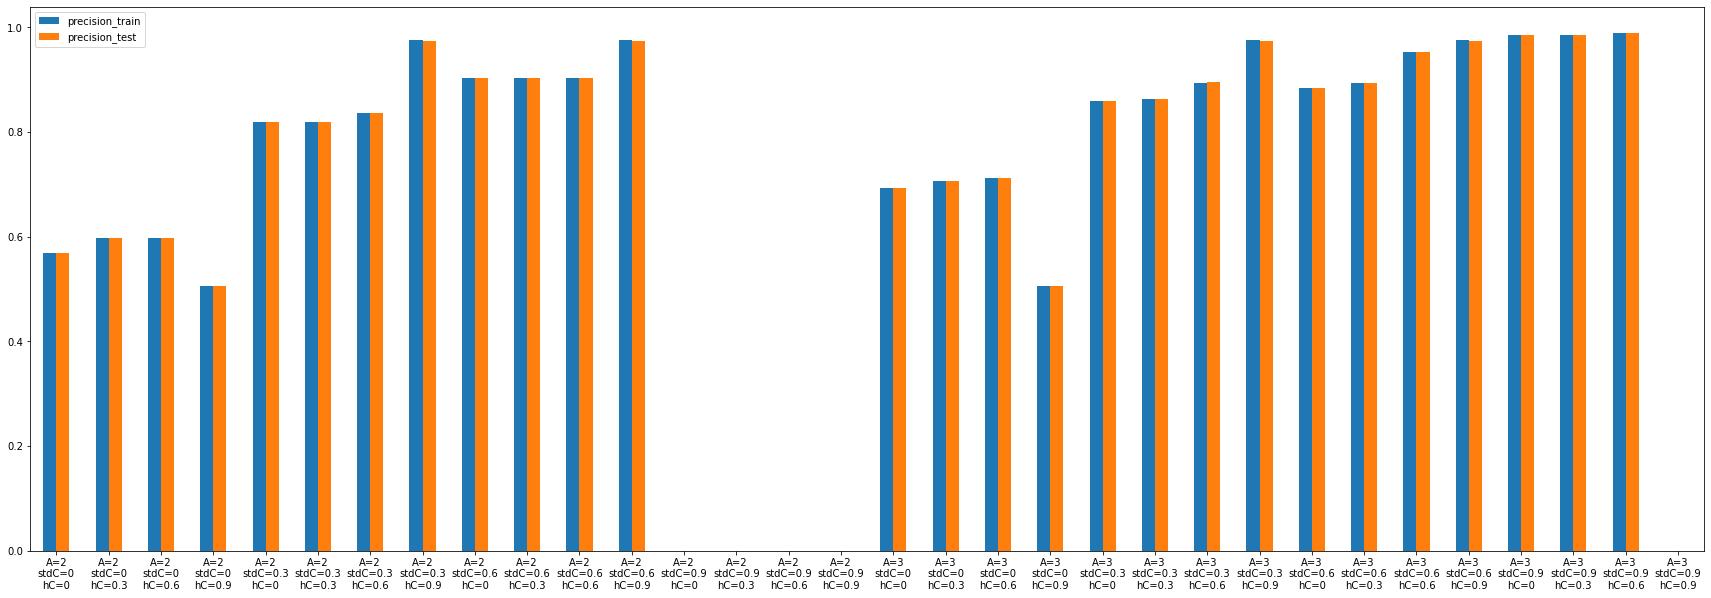

In [18]:
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 
to_print.plot(kind="bar", ax=_axs, rot=0)

# Now time to predict stuff

In [19]:
new_dfs.keys()

dict_keys(['A=2\nstdC=0\nhC=0', 'A=2\nstdC=0\nhC=0.3', 'A=2\nstdC=0\nhC=0.6', 'A=2\nstdC=0\nhC=0.9', 'A=2\nstdC=0.3\nhC=0', 'A=2\nstdC=0.3\nhC=0.3', 'A=2\nstdC=0.3\nhC=0.6', 'A=2\nstdC=0.3\nhC=0.9', 'A=2\nstdC=0.6\nhC=0', 'A=2\nstdC=0.6\nhC=0.3', 'A=2\nstdC=0.6\nhC=0.6', 'A=2\nstdC=0.6\nhC=0.9', 'A=2\nstdC=0.9\nhC=0', 'A=2\nstdC=0.9\nhC=0.3', 'A=2\nstdC=0.9\nhC=0.6', 'A=2\nstdC=0.9\nhC=0.9', 'A=3\nstdC=0\nhC=0', 'A=3\nstdC=0\nhC=0.3', 'A=3\nstdC=0\nhC=0.6', 'A=3\nstdC=0\nhC=0.9', 'A=3\nstdC=0.3\nhC=0', 'A=3\nstdC=0.3\nhC=0.3', 'A=3\nstdC=0.3\nhC=0.6', 'A=3\nstdC=0.3\nhC=0.9', 'A=3\nstdC=0.6\nhC=0', 'A=3\nstdC=0.6\nhC=0.3', 'A=3\nstdC=0.6\nhC=0.6', 'A=3\nstdC=0.6\nhC=0.9', 'A=3\nstdC=0.9\nhC=0', 'A=3\nstdC=0.9\nhC=0.3', 'A=3\nstdC=0.9\nhC=0.6', 'A=3\nstdC=0.9\nhC=0.9'])

In [20]:
def prepareVote(X, vote, rules_to_predict):
    prediction = []
    for rule in rules_to_predict.values:
        truth = rule[1].predicate == "approval-True"
        if truth: 
            if sum([X[i.predicate] for i in rule[0]]) == len(rule[0]):
                prediction.append("True")
            else:
                prediction.append("I can't say anything")
        else :
            if sum([X[i.predicate] for i in rule[0]]) == 0:
                prediction.append("False")
            else :
                prediction.append("I can't say anything")
    predicts = pd.Series(prediction).value_counts()    
    return vote(predicts)
    
def safe(X, rules_to_predict):
    prediction = []
    
    predicted_approved = False
    
    for rule in rules_to_predict.values:
        truth = rule[1].predicate == "approval-True"
        if truth and not predicted_approved: 
            if sum([X[i.predicate] for i in rule[0]]) == len(rule[0]):
                predicted_approved = True
        else :
            if sum([X[i.predicate] for i in rule[0]]) == 0:
                return "Not Approved"
    if predicted_approved:
        return "Approved"
    else:
        return "Not Approved - No rules was able to say anything"
    

def democracy(predicts):
    if not "False" in predicts:
        if not "Truth" in predicts:
            return "Not Approved - No rules was able to say anything"
        else:
            return "Approved"
    elif not "True" in predicts:
        return "Not Approved"
    else:
        if predicts["True"] < predicts["False"]:
            return "Not Approved"
        else:
            return "Approved"
        
def prepareVote_democracy_proportional(X, vote, rules_to_predict, proportion):
    prediction = []
    for rule in rules_to_predict.values:
        truth = rule[1].predicate == "approval-True"
        if truth: 
            if sum([X[i.predicate] for i in rule[0]]) == len(rule[0]):
                prediction.append("True")
            else:
                prediction.append("I can't say anything")
        else :
            if sum([X[i.predicate] for i in rule[0]]) == 0:
                prediction.append("False")
            else :
                prediction.append("I can't say anything")
    predicts = pd.Series(prediction).value_counts()    
    return vote(predicts, proportion)
        
def democracy_proportional(predicts, proportion):
    if not "False" in predicts:
        if not "Truth" in predicts:
            return "Not Approved - No rules was able to say anything"
        else:
            return "Approved"
    elif not "True" in predicts:
        return "Not Approved"
    else:
        if predicts["True"]*proportion["True"] < predicts["False"]*proportion["False"]:
            return "Not Approved"
        else:
            return "Approved"

def oligarchie(X, rules_to_predict):
    #Rules have to be sorted
    prediction = []
    
    cpt = 0
    while cpt < len(rules_to_predict):
        rule = rules_to_predict.iloc[cpt]
        truth = rule[1].predicate == "approval-True"
        
        if truth: 
            if sum([X[i.predicate] for i in rule[0]]) == len(rule[0]):
                return "Approved"
        else :
            if sum([X[i.predicate] for i in rule[0]]) == 0:
                return "Not Approved"
        cpt += 1
    return "Not Approved - No rules was able to say anything"

In [ ]:
# %%time

# final_prediction = []
# for j in range(len(df)):
#     example = df.iloc[j]
#     prediction = []
#     for rule in rules_to_predict.values:
#         truth = rule[1].predicate == "Approval-True"
#         if truth: 
#             if sum([example[i.predicate] for i in rule[0]]) == len(rule[0]):
#                 prediction.append("True")
#             else:
#                 prediction.append("I can't say anything")
#         else :
#             if sum([example[i.predicate] for i in rule[0]]) == 0:
#                 prediction.append("False")
#             else :
#                 prediction.append("I can't say anything")
#     predicts = pd.Series(prediction).value_counts()    
#     final_prediction.append(democracy(predicts))
    
# pd.Series(final_prediction).value_counts()

In [22]:
%%time

def paralel_prediction_res(parameters, index, new_dfs, res_count, res_raw, cpt ):
    print(f"Process n°{index} : Launched")
    for para in parameters:
        rules_to_predict = new_dfs[para]
        
        true = 0
        false = 0

        for rule in rules_to_predict.values:
            if rule[1].predicate ==  "approval-True":
                true += 1
            else:
                false += 1

        proportion = {"True":1-true/(true+false+1), "False":1-false/(true+false+1)}

        final_prediction = df.apply(prepareVote_democracy_proportional, rules_to_predict=rules_to_predict, axis=1, vote=democracy_proportional, proportion=proportion)
        
        cpt.value += 1
        if (cpt.value%10 == 0):
            print(cpt)
            
        res_count[para] = pd.Series(final_prediction).value_counts()
        res_raw[para] = pd.Series(final_prediction).map({"Not Approved - No rules was able to say anything":False, "Not Approved":False, "Approved":True})
    print(f"Process n°{index} : Finished")
    


prediction_per_rules_count = {}
prediction_per_rules_raw = {}

df = pd.read_csv("./../dfSave.csv", index_col=0)

with Manager() as manager:

    processes_to_create = multiprocessing.cpu_count()-3
    processes = list()

    rules_list = list(new_dfs.keys())
    
    res_count = manager.dict()
    res_raw = manager.dict()
    cpt = manager.Value("d",0)

    for index in range(processes_to_create):
        x = Process(target=paralel_prediction_res, args=(rules_list[int(np.floor(index*len(rules_list)/processes_to_create)): int(np.floor((index+1)*len(rules_list)/processes_to_create))], index, new_dfs, res_count, res_raw, cpt))
        processes.append(x)
        x.start()

    for index, process in enumerate(processes):
        process.join()
        
    prediction_per_rules_count = res_count.copy()
    prediction_per_rules_raw = res_raw.copy()

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched

<ipython-input-20-98d60353ff16>:65: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predicts = pd.Series(prediction).value_counts()



Process n°7 : Launched

<ipython-input-20-98d60353ff16>:65: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predicts = pd.Series(prediction).value_counts()



Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Value('d', 10)
Process n°5 : Finished
Process n°3 : Finished
Process n°11 : Finished


<ipython-input-20-98d60353ff16>:65: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predicts = pd.Series(prediction).value_counts()


Process n°1 : Finished
Value('d', 20)
Process n°4 : Finished
Process n°12 : Finished
Process n°9 : Finished
Process n°2 : Finished
Process n°0 : Finished
Process n°6 : Finished
Value('d', 30)
Process n°7 : Finished
Process n°10 : Finished
Process n°8 : Finished
CPU times: user 234 ms, sys: 13.9 s, total: 14.1 s
Wall time: 13min 15s


In [23]:
def compare(prediction, ground_truth):
    if len(prediction) != len(ground_truth):
        print("Different size")
        return None
    return sum(np.array(prediction) == np.array(ground_truth))/float(len(ground_truth))

In [24]:
accuracy_prediction = {}

for key in prediction_per_rules_raw:
    accuracy_prediction[key] = compare(prediction_per_rules_raw[key], df["approval"].values)

accuracy_prediction = pd.DataFrame.from_dict(accuracy_prediction, orient="index", columns=["Accuracy-democracy-propor"])

<AxesSubplot:>

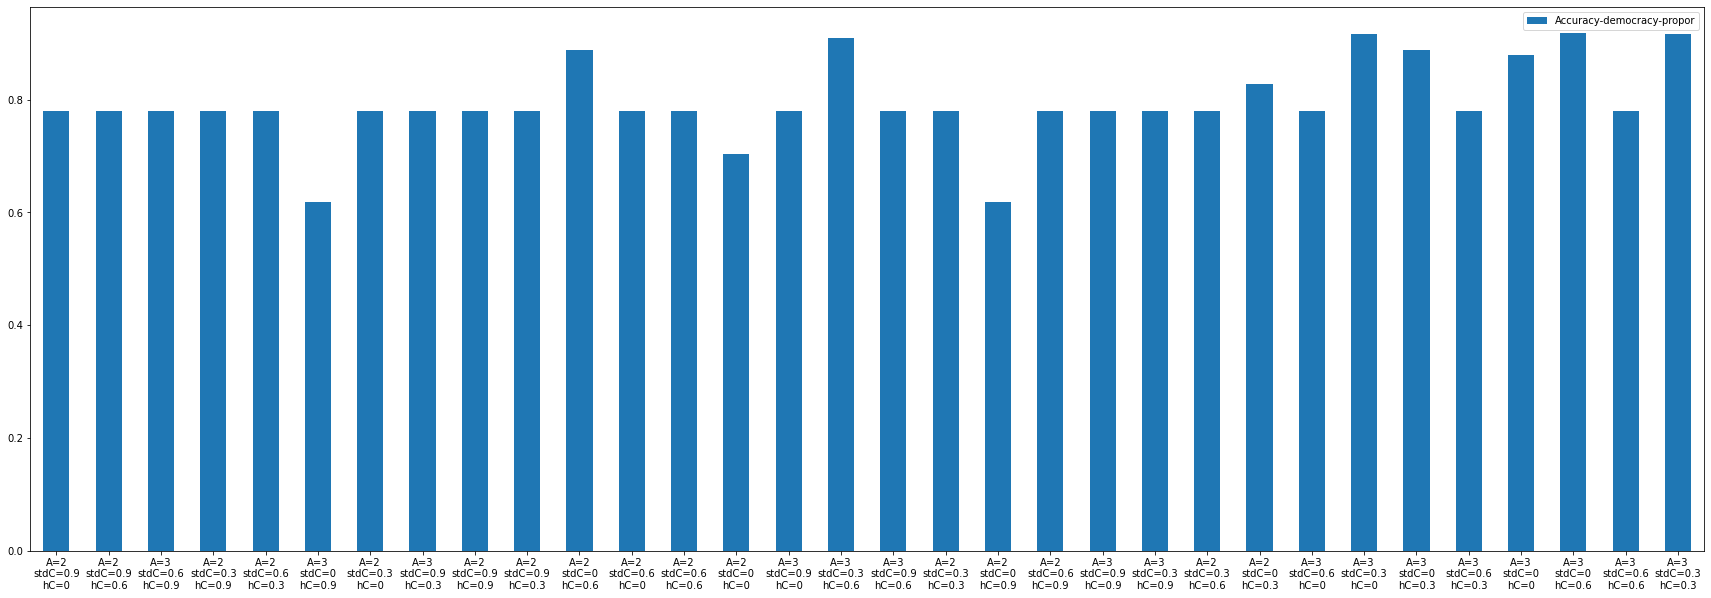

In [25]:
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 

to_print_1 = pd.DataFrame(accuracy_prediction)
to_print_1.plot(kind="bar", ax=_axs, rot=0)

<AxesSubplot:>

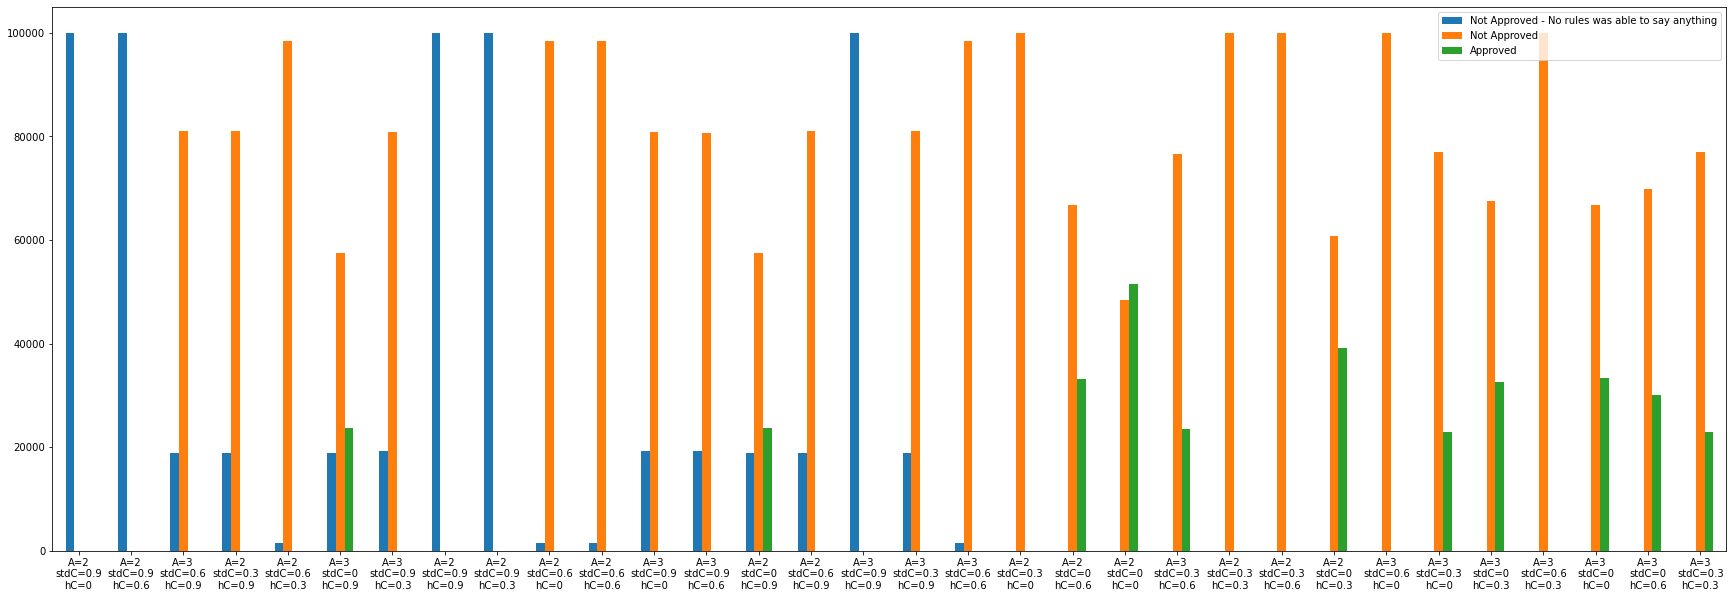

In [26]:
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 

to_print_count = pd.DataFrame.from_dict(prediction_per_rules_count, orient="index")
to_print_count.plot(kind="bar", ax=_axs, rot=0)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched


<ipython-input-20-98d60353ff16>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predicts = pd.Series(prediction).value_counts()


Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Value('d', 10)


<ipython-input-20-98d60353ff16>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predicts = pd.Series(prediction).value_counts()


Process n°2 : Finished
Value('d', 20)


<ipython-input-20-98d60353ff16>:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predicts = pd.Series(prediction).value_counts()


Process n°6 : Finished
Process n°1 : Finished
Process n°0 : Finished
Value('d', 30)
Process n°5 : Finished
Process n°4 : Finished
Process n°3 : Finished
CPU times: user 7.16 s, sys: 11.5 s, total: 18.7 s
Wall time: 18min 1s


<AxesSubplot:>

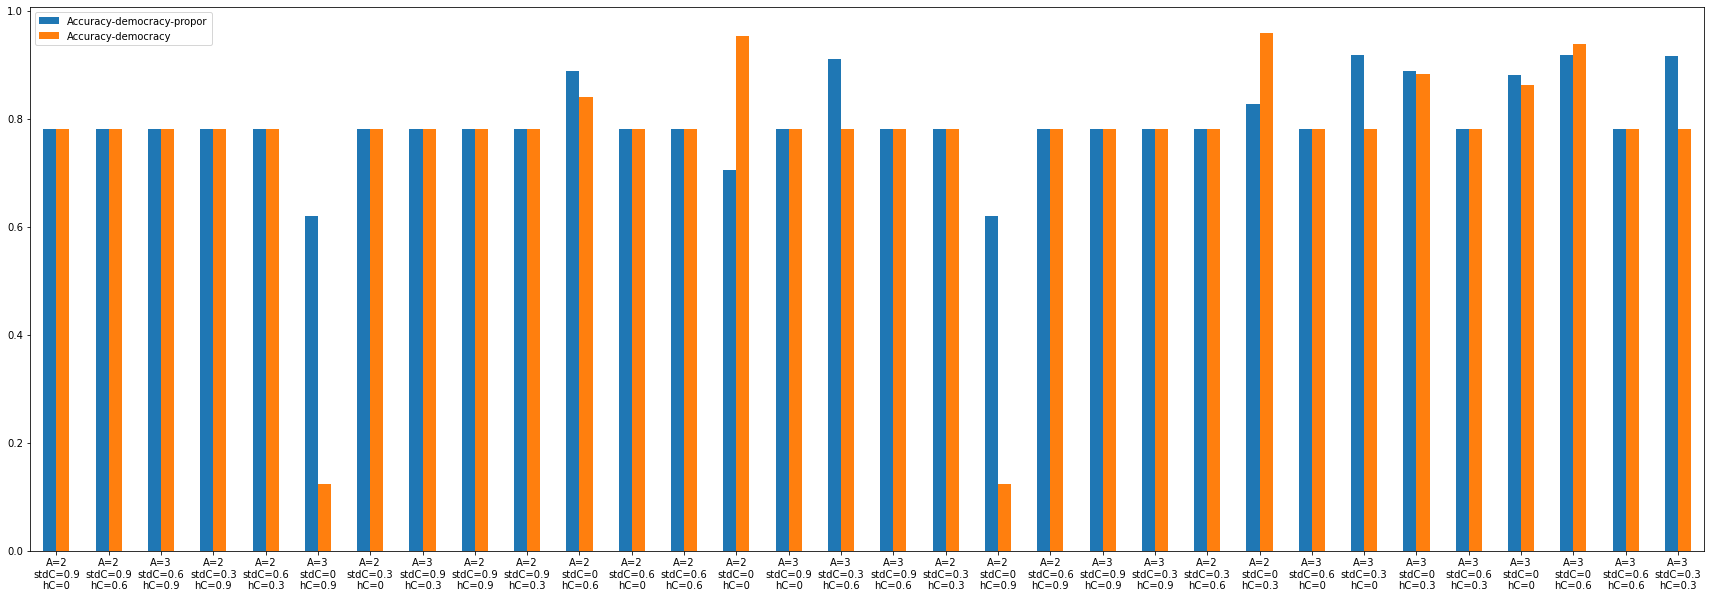

In [27]:
%%time

def paralel_prediction_res(parameters, index, new_dfs, res_count, res_raw, cpt ):
    print(f"Process n°{index} : Launched")
    for para in parameters:
        rules_to_predict = new_dfs[para]

        final_prediction = df.apply(prepareVote, rules_to_predict=rules_to_predict, axis=1, vote=democracy)
        
        cpt.value += 1
        if (cpt.value%10 == 0):
            print(cpt)
            
        res_count[para] = pd.Series(final_prediction).value_counts()
        res_raw[para] = pd.Series(final_prediction).map({"Not Approved - No rules was able to say anything":False, "Not Approved":False, "Approved":True})
    print(f"Process n°{index} : Finished")
    


prediction_per_rules_count = {}
prediction_per_rules_raw = {}

df = pd.read_csv("./../dfSave.csv", index_col=0)

with Manager() as manager:

    processes_to_create = multiprocessing.cpu_count()-3
    processes = list()

    rules_list = list(new_dfs.keys())
    
    res_count = manager.dict()
    res_raw = manager.dict()
    cpt = manager.Value("d",0)

    for index in range(processes_to_create):
        x = Process(target=paralel_prediction_res, args=(rules_list[int(np.floor(index*len(rules_list)/processes_to_create)): int(np.floor((index+1)*len(rules_list)/processes_to_create))], index, new_dfs, res_count, res_raw, cpt))
        processes.append(x)
        x.start()

    for index, process in enumerate(processes):
        process.join()
        
    prediction_per_rules_count = res_count.copy()
    prediction_per_rules_raw = res_raw.copy()
    
accuracy_prediction = {}

for key in prediction_per_rules_raw:
    accuracy_prediction[key] = compare(prediction_per_rules_raw[key], df["approval"].values)

accuracy_prediction = pd.DataFrame.from_dict(accuracy_prediction, orient="index", columns=["Accuracy-democracy"])

fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 

to_print_2 = to_print_1.merge(accuracy_prediction, left_index=True, right_index=True)
to_print_2.plot(kind="bar", ax=_axs, rot=0)

<AxesSubplot:>

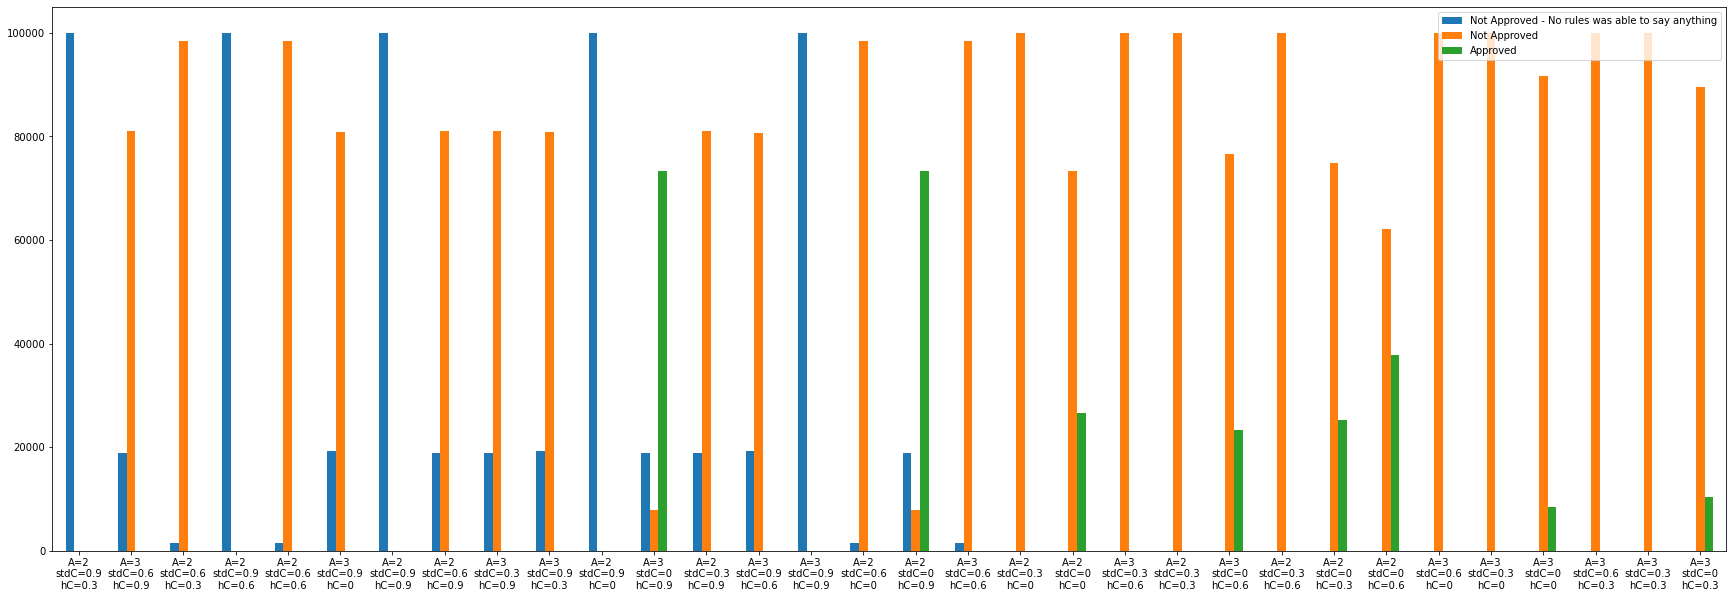

In [28]:
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 

to_print_count = pd.DataFrame.from_dict(prediction_per_rules_count, orient="index")
to_print_count.plot(kind="bar", ax=_axs, rot=0)

<AxesSubplot:>

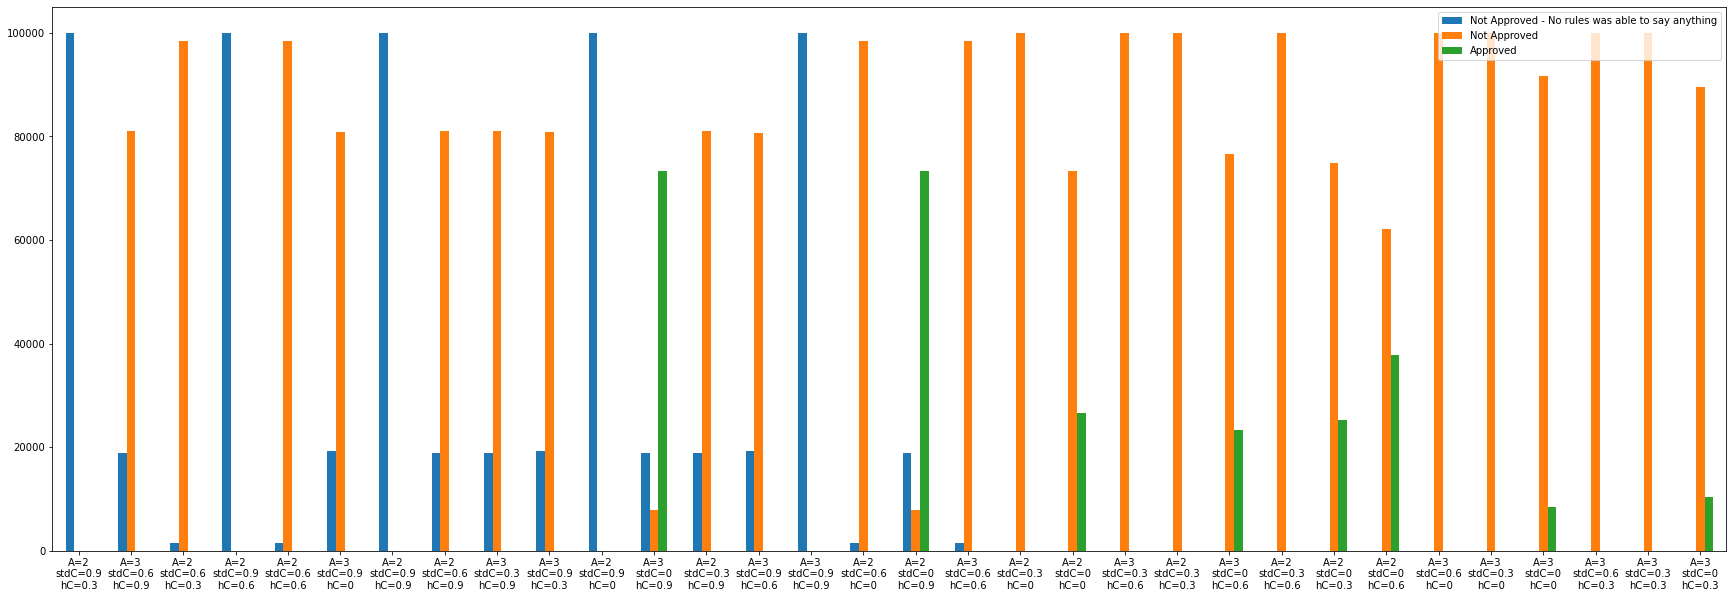

In [29]:
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 

to_print_count = pd.DataFrame.from_dict(prediction_per_rules_count, orient="index")
to_print_count.plot(kind="bar", ax=_axs, rot=0)

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Value('d', 10)
Process n°3 : Finished
Value('d', 20)
Process n°2 : Finished
Process n°1 : Finished
Process n°0 : Finished
Process n°5 : Finished
Value('d', 30)
Process n°6 : Finished
Process n°4 : Finished
Process n°7 : Finished
CPU times: user 7.09 s, sys: 11.9 s, total: 19 s
Wall time: 1min 9s


<AxesSubplot:>

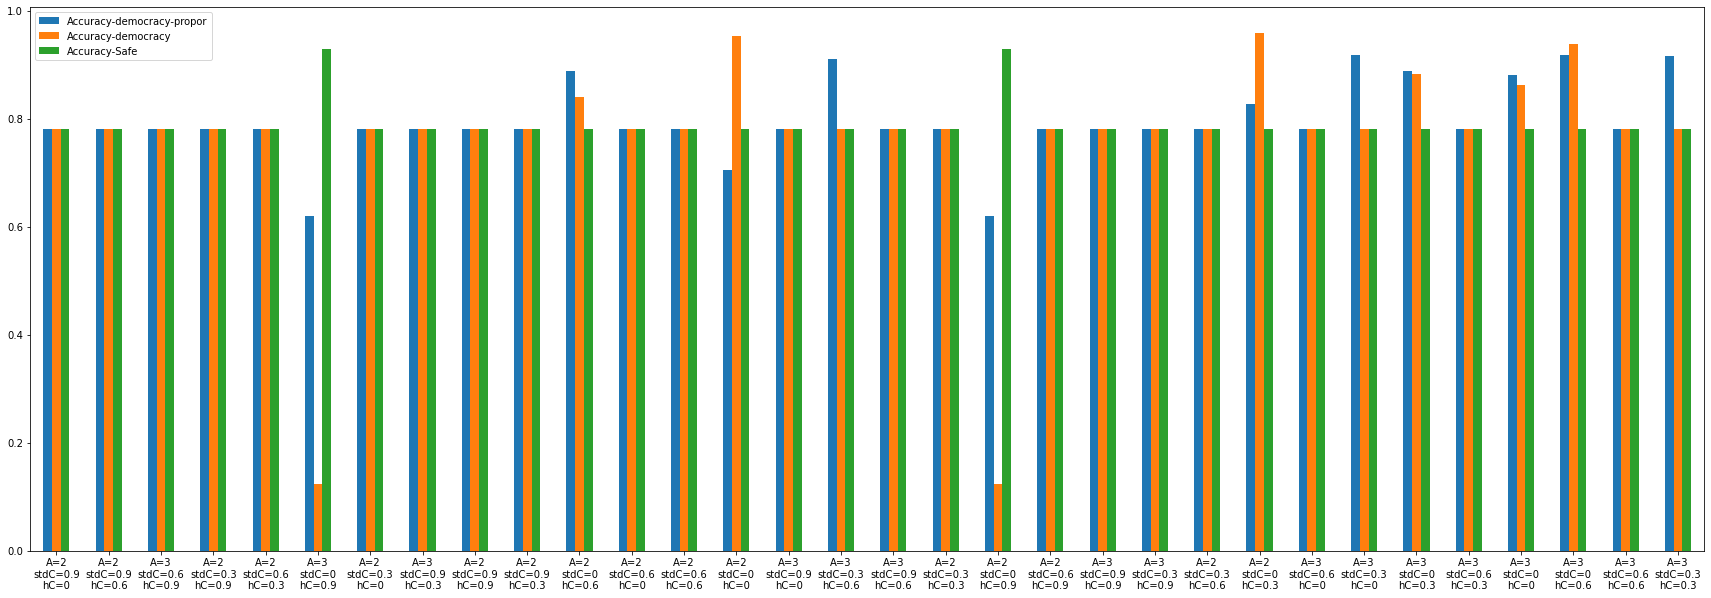

In [30]:
%%time

def paralel_prediction_res(parameters, index, new_dfs, res_count, res_raw, cpt ):
    print(f"Process n°{index} : Launched")
    for para in parameters:
        rules_to_predict = new_dfs[para]
        
        final_prediction = df.apply(safe, rules_to_predict=rules_to_predict, axis=1)
        
        cpt.value += 1
        if (cpt.value%10 == 0):
            print(cpt)
            
        res_count[para] = pd.Series(final_prediction).value_counts()
        res_raw[para] = pd.Series(final_prediction).map({"Not Approved - No rules was able to say anything":False, "Not Approved":False, "Approved":True})
    print(f"Process n°{index} : Finished")
    


prediction_per_rules_count = {}
prediction_per_rules_raw = {}

df = pd.read_csv("./../dfSave.csv", index_col=0)

with Manager() as manager:

    processes_to_create = multiprocessing.cpu_count()-3
    processes = list()

    rules_list = list(new_dfs.keys())
    
    res_count = manager.dict()
    res_raw = manager.dict()
    cpt = manager.Value("d",0)

    for index in range(processes_to_create):
        x = Process(target=paralel_prediction_res, args=(rules_list[int(np.floor(index*len(rules_list)/processes_to_create)): int(np.floor((index+1)*len(rules_list)/processes_to_create))], index, new_dfs, res_count, res_raw, cpt))
        processes.append(x)
        x.start()

    for index, process in enumerate(processes):
        process.join()
        
    prediction_per_rules_count = res_count.copy()
    prediction_per_rules_raw = res_raw.copy()
    
accuracy_prediction = {}

for key in prediction_per_rules_raw:
    accuracy_prediction[key] = compare(prediction_per_rules_raw[key], df["approval"].values)

accuracy_prediction = pd.DataFrame.from_dict(accuracy_prediction, orient="index", columns=["Accuracy-Safe"])

fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 

to_print_3 = to_print_2.merge(accuracy_prediction, left_index=True, right_index=True)
to_print_3.plot(kind="bar", ax=_axs, rot=0)

<AxesSubplot:>

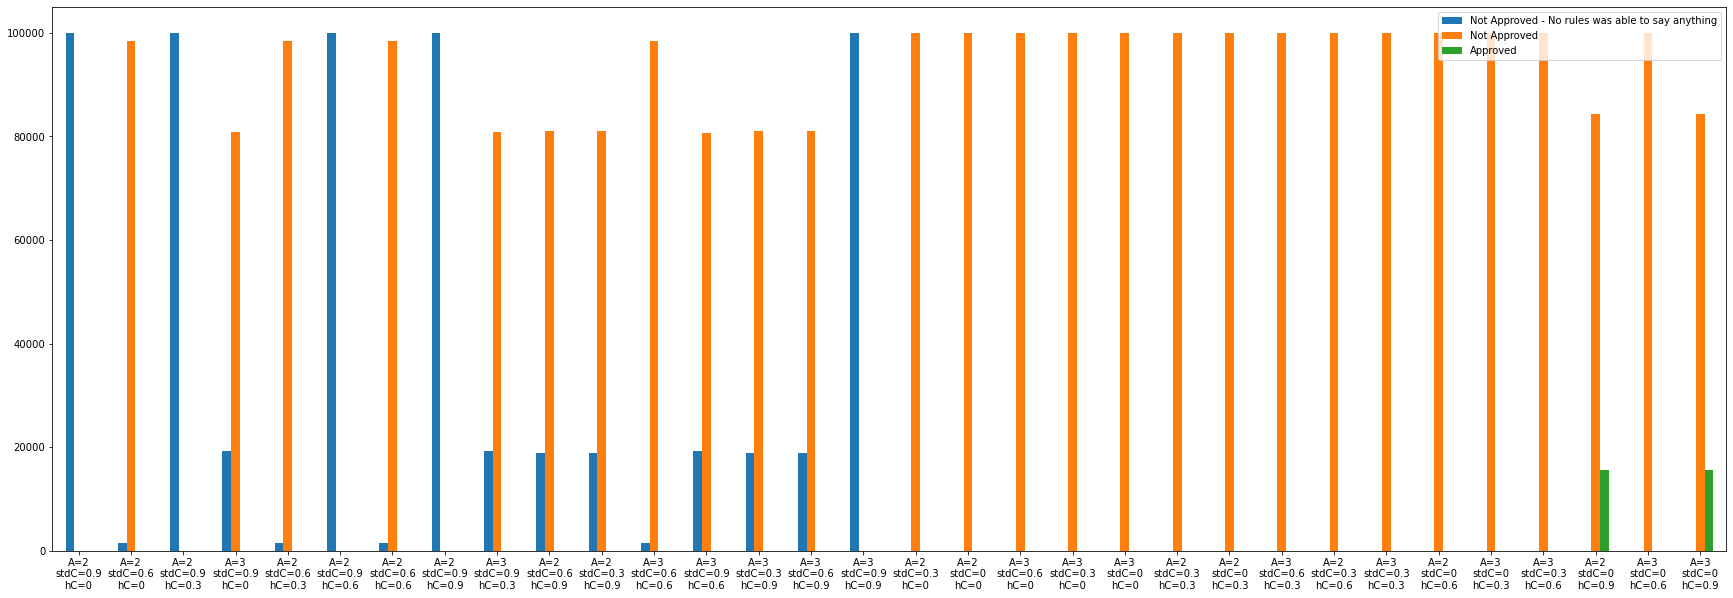

In [31]:
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 

to_print_count = pd.DataFrame.from_dict(prediction_per_rules_count, orient="index")
to_print_count.plot(kind="bar", ax=_axs, rot=0)

<AxesSubplot:>

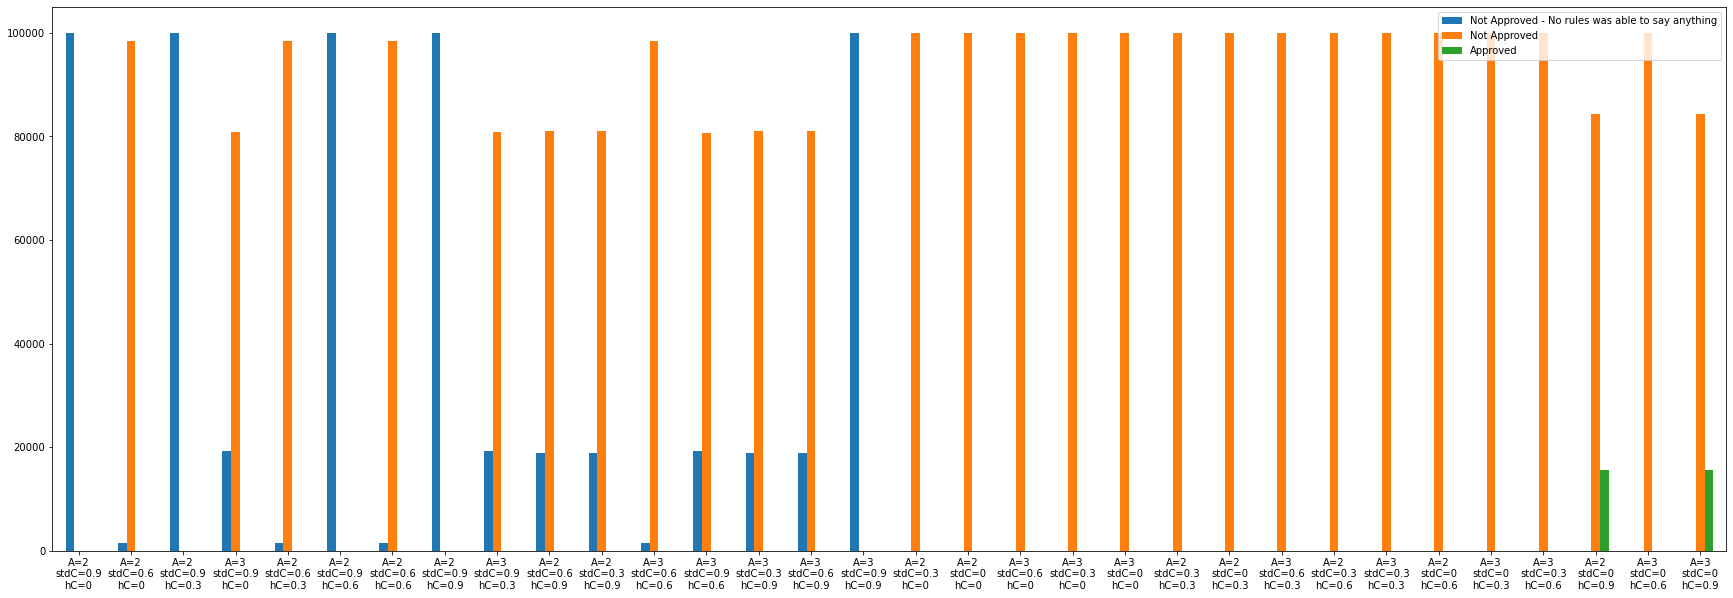

In [32]:
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 

to_print_count = pd.DataFrame.from_dict(prediction_per_rules_count, orient="index")
to_print_count.plot(kind="bar", ax=_axs, rot=0)

In [33]:
def paralel_prediction_res(parameters, index, new_dfs, res_count, res_raw, cpt ):
    print(f"Process n°{index} : Launched")
    for para in parameters:
        rules_to_predict = new_dfs[para].sort_values(["precision_train", "precision_test"], ascending=False)
        
        true = 0
        false = 0

        for rule in rules_to_predict.values:
            if rule[1].predicate ==  "approval-True":
                true += 1
            else:
                false += 1

        proportion = {"True":1-true/(true+false+1), "False":1-false/(true+false+1)}

        final_prediction = df.apply(oligarchie, rules_to_predict=rules_to_predict, axis=1)
        
        cpt.value += 1
        if (cpt.value%10 == 0):
            print(cpt)
            
        res_count[para] = pd.Series(final_prediction).value_counts()
        res_raw[para] = pd.Series(final_prediction).map({"Not Approved - No rules was able to say anything":False, "Not Approved":False, "Approved":True})
    print(f"Process n°{index} : Finished")

prediction_per_rules_count = {}
prediction_per_rules_raw = {}

df = pd.read_csv("./../dfSave.csv", index_col=0)

with Manager() as manager:

    processes_to_create = multiprocessing.cpu_count()-3
    processes = list()

    rules_list = list(new_dfs.keys())
    
    res_count = manager.dict()
    res_raw = manager.dict()
    cpt = manager.Value("d",0)

    for index in range(processes_to_create):
        x = Process(target=paralel_prediction_res, args=(rules_list[int(np.floor(index*len(rules_list)/processes_to_create)): int(np.floor((index+1)*len(rules_list)/processes_to_create))], index, new_dfs, res_count, res_raw, cpt))
        processes.append(x)
        x.start()

    for index, process in enumerate(processes):
        process.join()
        
    prediction_per_rules_count = res_count.copy()
    prediction_per_rules_raw = res_raw.copy()

Process n°0 : Launched
Process n°1 : Launched
Process n°2 : Launched
Process n°3 : Launched
Process n°4 : Launched
Process n°5 : Launched
Process n°6 : Launched
Process n°7 : Launched
Process n°8 : Launched
Process n°9 : Launched
Process n°10 : Launched
Process n°11 : Launched
Process n°12 : Launched
Process n°5 : Finished
Value('d', 10)
Process n°3 : Finished
Process n°1 : Finished
Process n°4 : Finished
Process n°11 : Finished
Process n°0 : Finished
Value('d', 20)
Process n°2 : Finished
Process n°12 : Finished
Process n°9 : Finished
Process n°6 : Finished
Process n°7 : Finished
Value('d', 30)
Process n°8 : Finished
Process n°10 : Finished


In [34]:
accuracy_prediction = {}

for key in prediction_per_rules_raw:
    accuracy_prediction[key] = compare(prediction_per_rules_raw[key], df["approval"].values)

accuracy_prediction = pd.DataFrame.from_dict(accuracy_prediction, orient="index", columns=["Accuracy-expert"])

<AxesSubplot:>

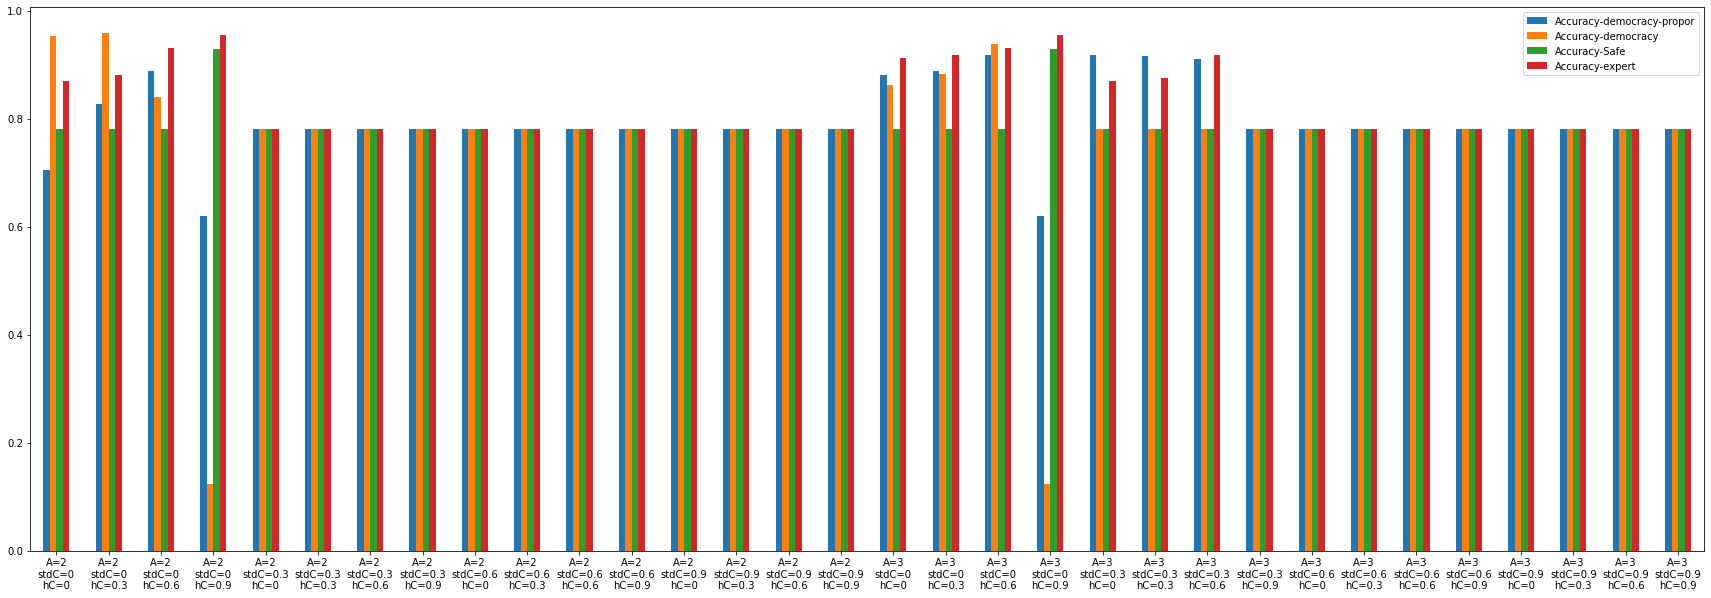

In [37]:
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 

to_print_4 = to_print_3.merge(accuracy_prediction, left_index=True, right_index=True)
to_print_4.sort_index().plot(kind="bar", ax=_axs, rot=0)

<AxesSubplot:>

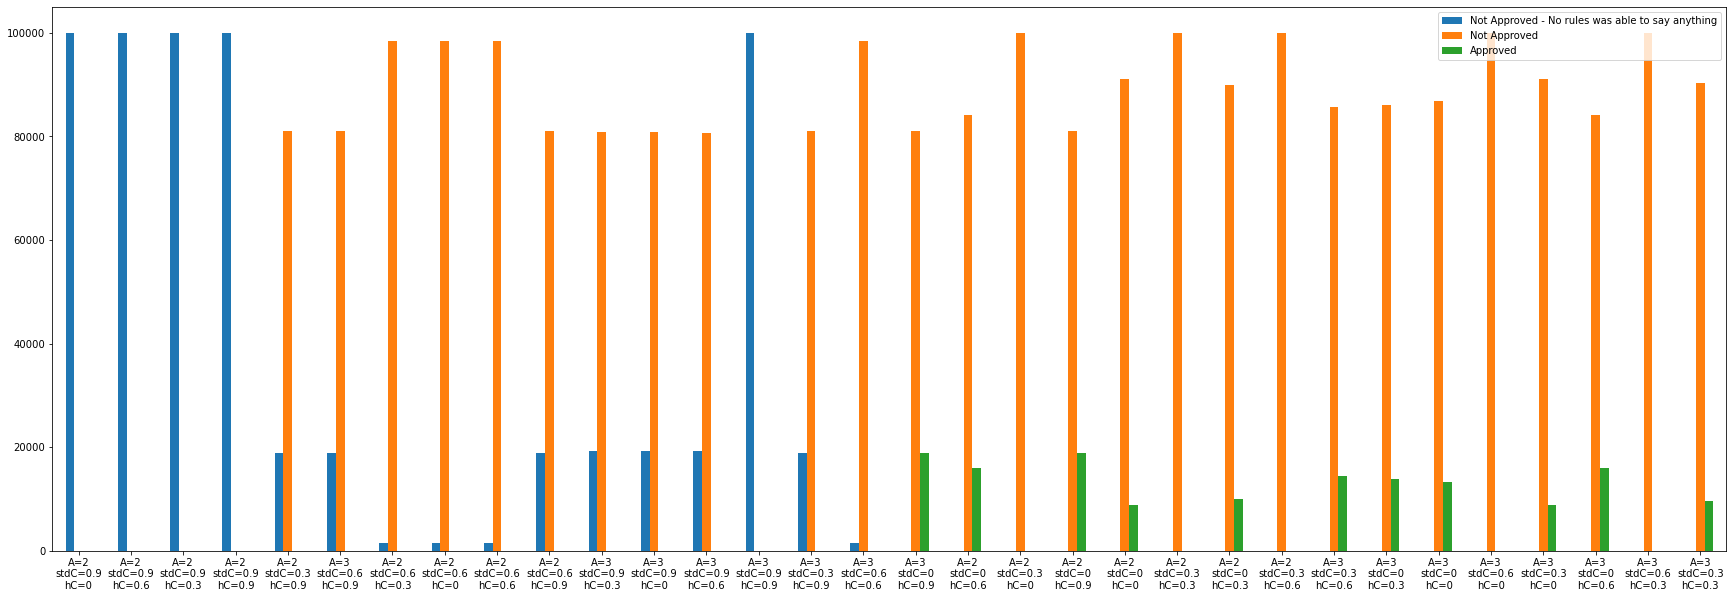

In [36]:
fig, _axs = plt.subplots(nrows=1, ncols=1, figsize=(30,10)) 

to_print_count = pd.DataFrame.from_dict(prediction_per_rules_count, orient="index")
to_print_count.sort_index().plot(kind="bar", ax=_axs, rot=0)